# Capacity prediction

## Notebook 5: Classification Model 

**Author:** ACG  
**Date:** `2024/06`  
**Version:** 1.0  

---

### Table of Contents
1. [Random Forest](#random-forest)
2. [XGBoost](#xgboost)

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from utils.properties import *
import matplotlib.pyplot as plt
import seaborn as sbn

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
seed = 1862

## Import dataset

In [3]:
df = pd.read_csv(DATASET_FINAL, sep=';')
df_features = df.drop(['capacity'], axis=1)

## Transformation to a classification problem

We want to transform the target variable **'capacity'** into a categorical variable with 3 categories: low, medium and high. To do this we will use the 3 cuartiles as thresholds for each.

In [4]:
df['capacity'].describe()

count    588.000000
mean      32.005102
std        7.193479
min       15.000000
25%       26.000000
50%       32.000000
75%       37.000000
max       53.000000
Name: capacity, dtype: float64

In [5]:
df['capacity_level'] = df['capacity'].apply(lambda x: 'low' if x <= 26 else ('medium' if x <= 37 else 'high'))

In [6]:
df[['capacity','capacity_level']]

,capacity,capacity_level
0,38,high
1,38,high
2,35,medium
3,35,medium
4,35,medium
...,...,...
583,30,medium
584,25,low
585,30,medium
586,30,medium


In [7]:
df['capacity_level'].value_counts()

capacity_level
medium    292
low       150
high      146
Name: count, dtype: int64

In [8]:
df_target = df['capacity_level']
df = df.drop(['capacity'], axis=1)

# 1. Random Forest <a id="random-forest"></a>

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

## Train

In [10]:
x_train, x_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.2, random_state=seed)
rf_base = RandomForestClassifier(random_state=seed)

In [11]:
params = {
    'n_estimators': [50,100,150],
    'criterion': ['gini','entropy'],
    'max_depth':[5, 8, 13, 20],
    'min_samples_split':[2, 4, 8, 16, 40]
}
metrics = ['accuracy','precision_macro','recall_macro']

In [12]:
grid = GridSearchCV(
    estimator=rf_base,
    param_grid=params,
    cv=5,
    scoring=metrics,
    refit='accuracy'
)
grid.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1862),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 8, 13, 20],
                         'min_samples_split': [2, 4, 8, 16, 40],
                         'n_estimators': [50, 100, 150]},
             refit='accuracy',
             scoring=['accuracy', 'precision_macro', 'recall_macro'])

## Evaluation

In [13]:
best_model_tr = grid.best_estimator_
y_pred = best_model_tr.predict(x_test)

print(best_model_tr)
print(f"parameters: {grid.best_params_}")
print(f"Accuracy: {grid.best_score_}")

RandomForestClassifier(max_depth=13, min_samples_split=4, n_estimators=150,
                       random_state=1862)
parameters: {'criterion': 'gini', 'max_depth': 13, 'min_samples_split': 4, 'n_estimators': 150}
Accuracy: 0.7574468085106383


In [14]:
# top 5 results by accuracy
results = pd.DataFrame(grid.cv_results_).sort_values(by='mean_test_accuracy', ascending=False)
results[['param_criterion','param_n_estimators','param_max_depth','mean_test_accuracy','mean_test_precision_macro',
        'mean_test_recall_macro']].head(5)

,param_criterion,param_n_estimators,param_max_depth,mean_test_accuracy,mean_test_precision_macro,mean_test_recall_macro
35,gini,150,13,0.757447,0.774603,0.733887
91,entropy,100,13,0.755319,0.771532,0.731684
34,gini,100,13,0.755319,0.771916,0.731937
50,gini,150,20,0.753191,0.773188,0.726230
92,entropy,150,13,0.748936,0.766289,0.726018


### Confusion matrix

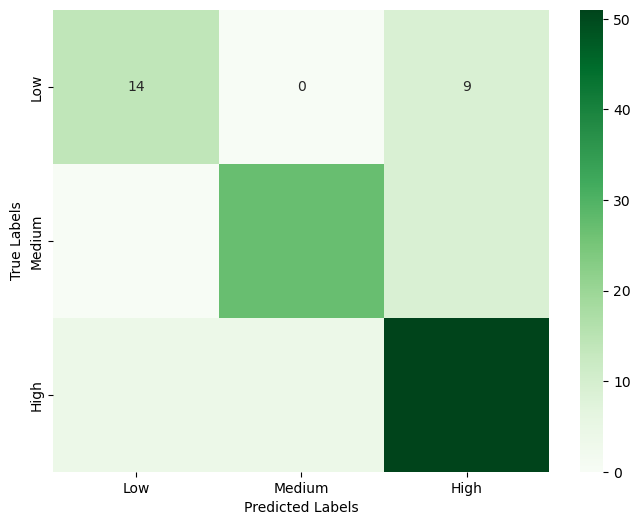

In [15]:
cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(8,6))
sbn.heatmap(cm,annot=True,cmap='Greens',xticklabels=['Low','Medium','High'],yticklabels=['Low','Medium','High'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Features importances

In [16]:
from utils.eda_utils import plot_features_imp

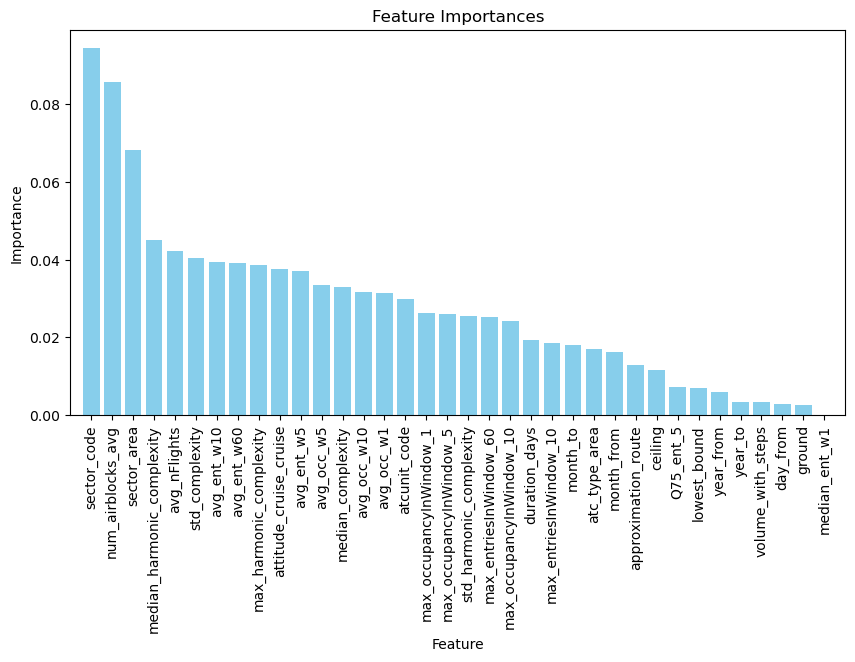

In [17]:
# train the best model
rfc = RandomForestClassifier(n_estimators=150,criterion='gini',max_depth=13,min_samples_split=4,random_state=seed)
rfc.fit(x_train,y_train)

# Get feature importances
importances = rfc.feature_importances_
plot_features_imp(importances,x_train)

# 2. XGBoost <a id="xgboost"></a>

In [18]:
from xgboost import XGBClassifier

In [19]:
# aplicar label encoding a target
df['capacity_le'] = df_target.replace(['low','medium','high'], [0,1,2])

In [20]:
x_train, x_test, y_train, y_test = train_test_split(df_features, df['capacity_le'], test_size=0.2, random_state=seed)

In [21]:
xgb_base = XGBClassifier(random_state=seed)
params = {
    'n_estimators': [50,100,150],
    'max_depth':[5, 8, 13, 20],
    'criterion':['gini','entropy'],
    'min_samples_split':[2, 4, 8, 16, 40]
}
metrics = ['accuracy','precision_macro','recall_macro']

In [22]:
grid_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=params,
    cv=5,
    scoring=metrics,
    refit='accuracy'
)
grid_xgb.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=1862, ...),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 8, 13, 20],
                         'min_samples_split': [2, 4, 8, 16, 40],
                         'n_estimators': [50, 100, 150]},
             refit='accuracy',
             scoring=['accuracy', 'precision_macro', 'recall_macro'])

In [23]:
best_model_tr = grid_xgb.best_estimator_
y_pred = best_model_tr.predict(x_test)

print(best_model_tr)
print(f"parameters: {grid_xgb.best_params_}")
print(f"Accuracy: {grid_xgb.best_score_}")

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, criterion='gini', device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, min_samples_split=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, ...)
parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.7936170212765957


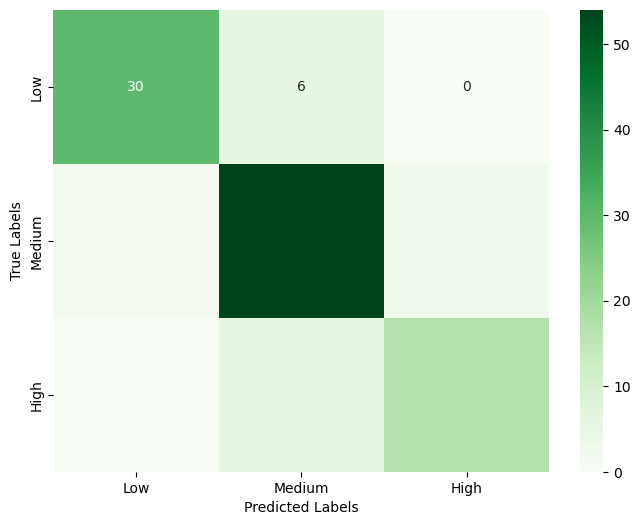

In [24]:
cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(8,6))
sbn.heatmap(cm,annot=True,cmap='Greens',xticklabels=['Low','Medium','High'],yticklabels=['Low','Medium','High'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Features importances

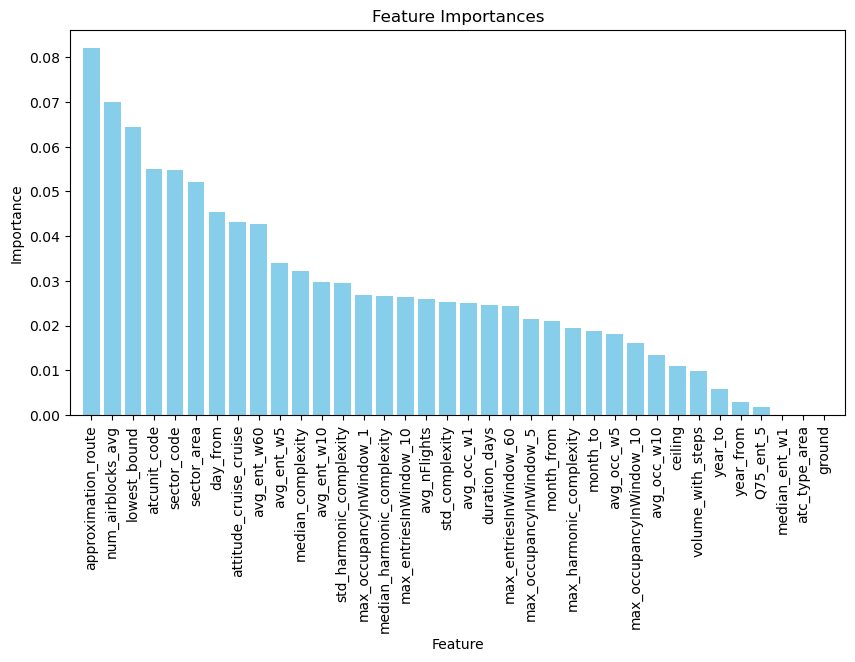

In [25]:
# best model
xgb = XGBClassifier(n_estimators=50,criterion='gini',max_depth=5,min_samples_split=2,random_state=seed)
xgb.fit(x_train,y_train)

importances = xgb.feature_importances_
plot_features_imp(importances,x_train)